In [2]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.convolution import Gaussian2DKernel

from mrf.display import display_single, SEG_CMAP, draw_circles
from mrf.task import MrfTask
from mrf.utils import bright_star_mask
from mrf.celestial import Celestial

import sep

import pymfit

plt.rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# from kuaizi.utils import set_matplotlib
# set_matplotlib(fontsize=12)

In [308]:
img_fn = './n5846_g_halosub.fits'
mask_fn = './n5846_g_full_mask.fits'
var_fn = './n5846_g_invvar.fits'
psf_fn = './median_psf_g.fits'

In [233]:
from mrf.utils import save_to_fits
hdu = fits.open(mask_fn)[0]
img = Celestial(hdu.data, header=hdu.header)
img.resize_image(1/2, method='iraf')
mask = (img.image > 0)
save_to_fits(mask.astype(int), './binned_mask_g.fits', header=img.header)

In [234]:
hdu = fits.open(img_fn)[0]
img = Celestial(hdu.data, header=hdu.header)
img.resize_image(1/2, method='iraf')
#save_to_fits(img.image * (~mask), './binned_img_g.fits', header=img.header)
img.save_to_fits('./binned_img_g.fits')

In [235]:
hdu = fits.open(var_fn)[0]
img = Celestial(hdu.data, header=hdu.header)
img.resize_image(1/2, method='iraf')
img.save_to_fits('./binned_invvar_g.fits')

In [309]:
hdu = fits.open(psf_fn)[0]
img = Celestial(hdu.data, header=img.header)
img.resize_image(1/2, method='iraf')
img.save_to_fits('./binned_psf_g.fits')

In [326]:
img_fn = './binned_img_g.fits'
mask_fn = './binned_mask_g.fits'
var_fn = './binned_invvar_g.fits'
psf_fn = './binned_psf_g.fits'

# img_fn = './n5846_g_halosub.fits'
# mask_fn = './n5846_g_full_mask.fits'
# var_fn = './n5846_g_invvar.fits'
# psf_fn = './median_psf_g.fits'

init_params = dict(
    PA=[0, -90, 90],
    n=[0.5, 0.1, 2.0],
)

In [327]:
config = pymfit.sersic_config(init_params, img_shape=img_fn, delta_pos=5)

In [328]:
sersic = pymfit.run(
    img_fn,
    config_fn='./config.txt',
    mask_fn=mask_fn,
    psf_fn=psf_fn,
    config=config,
    var_fn=var_fn,
    out_fn='./best-fit-g.dat',
    options='--sky=0.0',
    weights=False,
    sigma=False,
    save_model=True,
    save_res=True)

imfit './binned_img_g.fits' -c ./config.txt --mask './binned_mask_g.fits' --noise './binned_invvar_g.fits' --errors-are-variances --psf './binned_psf_g.fits' --sky=0.0 --save-model ./binned_img_g_model.fits --save-residual ./binned_img_g_res.fits --save-params ./best-fit-g.dat


In [329]:
img_mrf = fits.open(img_fn)[0].data
img_decals = fits.open('./decals_g.fits')[0].data
mask_mrf = fits.open(mask_fn)[0].data.astype(bool)
fontsize = 10
band = 'g'
pixscale = 0.262

In [330]:
s = pymfit.Sersic(sersic, pixscale=pixscale, zpt=22.5) # Realize the Sersic model to an array
sersic_model = s.array(img_mrf.shape)

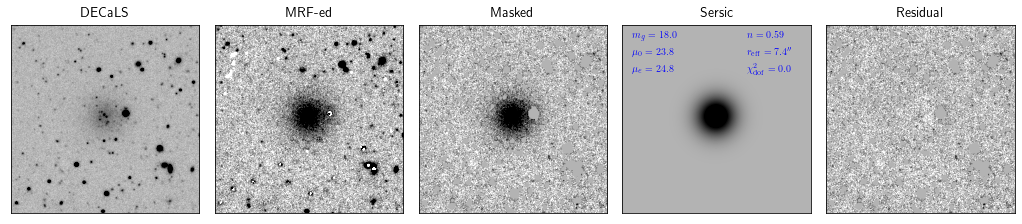

In [331]:
from mrf.display import display_multiple
from astropy.visualization import (ZScaleInterval,
                                   AsymmetricPercentileInterval)
zscale = ZScaleInterval()

subplot_kw = dict(xticks=[], yticks=[])
fig, axes = plt.subplots(1, 5, subplot_kw=subplot_kw, figsize=(18, 7))
fig.subplots_adjust(wspace=0.08)
titles = [
    'DECaLS', 'MRF-ed', 'Masked', 'Sersic', 'Residual'
]
vmin, vmax = zscale.get_limits(img_decals)

for i, data in enumerate([
        img_decals, img_mrf, img_mrf * (~mask_mrf), sersic_model,
        (img_mrf  - sersic_model) * (~mask_mrf)
]):
    show = axes[i].imshow(
        data,
        vmin=vmin,
        vmax=vmax,
        origin='lower',
        cmap=plt.cm.gray_r,
        aspect='equal',
        rasterized=True)
    axes[i].set_title(titles[i], fontsize=fontsize + 4, y=1.01)

x = 0.05
y = 0.93
dy = 0.09
dx = 0.61
fs = fontsize
if band is not None:
    m_tot = r'$m_'+band+' = '+str(round(s.m_tot, 1))+'$'
else:
    m_tot = r'$m = '+str(round(s.m_tot, 1))+'$'
r_e = r'$r_\mathrm{eff}='+str(round(s.r_e*pixscale,1))+'^{\prime\prime}$'
mu_0 = r'$\mu_0='+str(round(s.mu_0,1))+'$'
mu_e = r'$\mu_e='+str(round(s.mu_e,1))+'$'
n = r'$n = '+str(round(s.n,2))+'$'

c = 'b'

axes[3].text(x, y, m_tot, transform=axes[3].transAxes,
             fontsize=fs, color=c)
axes[3].text(x, y-dy, mu_0, transform=axes[3].transAxes,
             fontsize=fs, color=c)
axes[3].text(x, y-2*dy, mu_e, transform=axes[3].transAxes,
             fontsize=fs, color=c)
axes[3].text(x+dx, y, n, transform=axes[3].transAxes,
             fontsize=fs, color=c)
axes[3].text(x+dx, y-dy, r_e, transform=axes[3].transAxes,
             fontsize=fs, color=c)

if 'reduced_chisq' in list(sersic.keys()):
    chisq = r'$\chi^2_\mathrm{dof} = '+\
            str(round(sersic['reduced_chisq'],2))+'$'
    axes[3].text(x+dx, y-2*dy, chisq, transform=axes[3].transAxes,
                 fontsize=fs, color=c)
    
#plt.savefig('./sersic-fitting-r.png')

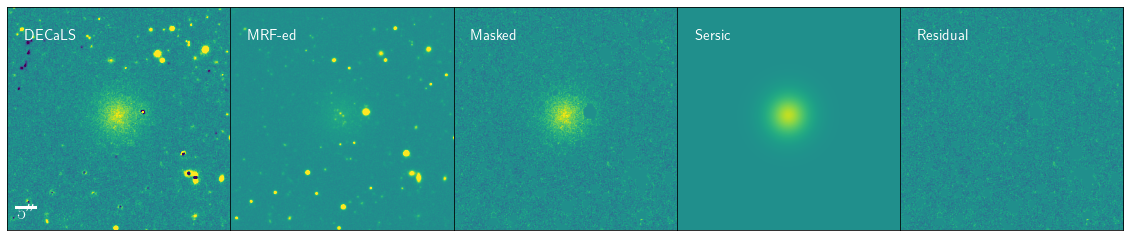

In [332]:
display_multiple(
    [
        img_mrf,
        img_decals,
        img_mrf * (~mask_mrf),
        sersic_model,
        (img_mrf  - sersic_model) * (~mask_mrf)
    ],
    text=['DECaLS', 'MRF-ed', 'Masked', 'Sersic', 'Residual'],
    text_fontsize=15,
    text_y_offset=0.9);